In [2]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)
%cd '/content/drive/My Drive/dataset'

Mounted at /content/drive
/content/drive/My Drive/dataset


In [1]:
from __future__ import print_function, division
from builtins import range, input

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, AveragePooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import cv2
from glob import glob

In [3]:
#define size to which images are to be resized
IMAGE_SIZE = [224, 224] # feel free to change depending on dataset

# training config:
epochs = 500
batch_size = 32

#define paths
covid_path = '/content/drive/MyDrive/dataset/covid'
noncovid_path = '/content/drive/MyDrive/dataset/normal'

# Use glob to grab images from path .jpg or jpeg
covid_files = glob(covid_path + '/*')
noncovid_files = glob(noncovid_path + '/*')

In [4]:
# Preparing Labels
covid_labels = []
noncovid_labels = []

covid_images=[]
noncovid_images=[]

import cv2 

for i in range(len(covid_files)):
  image = cv2.imread(covid_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(224,224))
  covid_images.append(image)
  covid_labels.append('Chest_COVID')
for i in range(len(noncovid_files)):
  image = cv2.imread(noncovid_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(224,224))
  noncovid_images.append(image)
  noncovid_labels.append('Chest_NonCOVID')

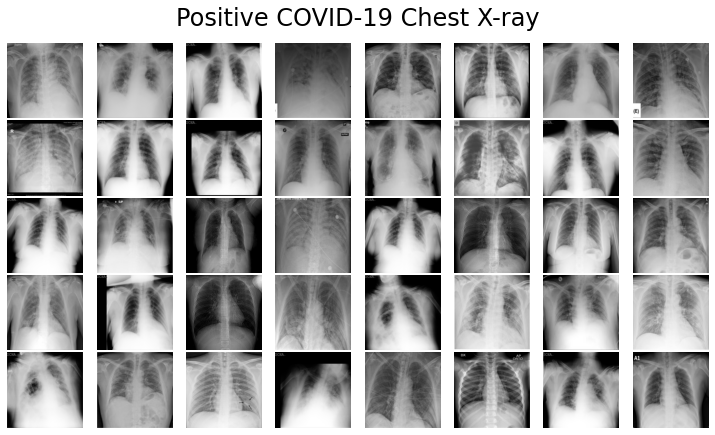

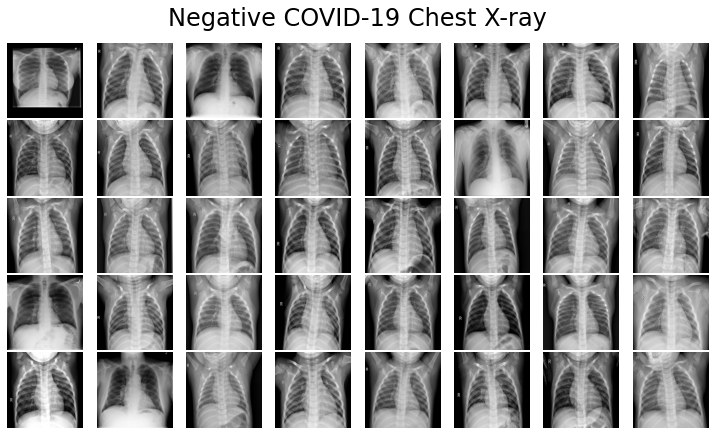

In [5]:
def plot_images(images, title):
    nrows, ncols = 5, 8
    figsize = [10, 6]

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, facecolor=(1, 1, 1))

    for i, axi in enumerate(ax.flat):
        axi.imshow(images[i])
        axi.set_axis_off()

    plt.suptitle(title, fontsize=24)
    plt.tight_layout(pad=0.2, rect=[0, 0, 1, 0.9])
    plt.show()
plot_images(covid_images, 'Positive COVID-19 Chest X-ray')
plot_images(noncovid_images, 'Negative COVID-19 Chest X-ray')

In [6]:
# normalize to interval of [0,1]
covid_images = np.array(covid_images) / 255
noncovid_images = np.array(noncovid_images) / 255

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

# split into training and testing
covid_x_train, covid_x_test, covid_y_train, covid_y_test = train_test_split(covid_images, covid_labels, test_size=0.2)
noncovid_x_train, noncovid_x_test, noncovid_y_train, noncovid_y_test = train_test_split(
    noncovid_images, noncovid_labels, test_size=0.2)


X_train = np.concatenate((noncovid_x_train, covid_x_train), axis=0)
X_test = np.concatenate((noncovid_x_test, covid_x_test), axis=0)
y_train = np.concatenate((noncovid_y_train, covid_y_train), axis=0)
y_test = np.concatenate((noncovid_y_test, covid_y_test), axis=0)

# make labels into categories - either 0 or 1
y_train = LabelBinarizer().fit_transform(y_train)
y_train = to_categorical(y_train)

y_test = LabelBinarizer().fit_transform(y_test)
y_test = to_categorical(y_test)

In [8]:
res = ResNet50(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

outputs = res.output
outputs = Flatten(name="flatten")(outputs)
outputs = Dropout(0.5)(outputs)
outputs = Dense(2, activation="softmax")(outputs)

model = Model(inputs=res.input, outputs=outputs)

for layer in res.layers:
    layer.trainable = False

model.compile(
        loss='categorical_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
)

train_aug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

94781440/94765736 [==============================] - 1s 0us/step


In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [10]:
len(model.layers)

178

In [12]:
history = model.fit(train_aug.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_test, y_test),
                    validation_steps=len(X_test) / 32,
                    steps_per_epoch=len(X_train) / 32,
                    epochs=10)

Epoch 1/10
15/15 [==============================] - 84s 6s/step - loss: 0.5223 - accuracy: 0.8000 - val_loss: 0.3902 - val_accuracy: 0.8750
Epoch 2/10
15/15 [==============================] - 84s 6s/step - loss: 0.4172 - accuracy: 0.8375 - val_loss: 0.3782 - val_accuracy: 0.8750
Epoch 3/10
15/15 [==============================] - 84s 6s/step - loss: 0.4945 - accuracy: 0.8208 - val_loss: 0.4113 - val_accuracy: 0.8333
Epoch 4/10
15/15 [==============================] - 84s 6s/step - loss: 0.6021 - accuracy: 0.7688 - val_loss: 0.4893 - val_accuracy: 0.8750
Epoch 5/10
15/15 [==============================] - 84s 6s/step - loss: 0.5949 - accuracy: 0.7917 - val_loss: 0.3823 - val_accuracy: 0.8667
Epoch 6/10
15/15 [==============================] - 84s 6s/step - loss: 0.4985 - accuracy: 0.8167 - val_loss: 0.3771 - val_accuracy: 0.8750
Epoch 7/10
15/15 [==============================] - 84s 6s/step - loss: 0.5588 - accuracy: 0.7833 - val_loss: 0.5195 - val_accuracy: 0.7917
Epoch 8/10
15/15 [==

In [13]:
model.save('resnet_chest.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [14]:
model.save_weights('resnetweights_chest.hdf5')

In [15]:
model = load_model('resnet_chest.h5')

In [16]:
y_pred = model.predict(X_test, batch_size=batch_size)

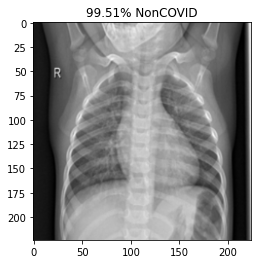

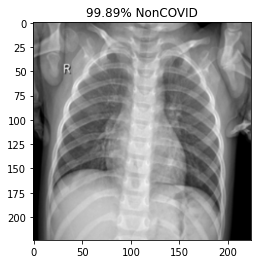

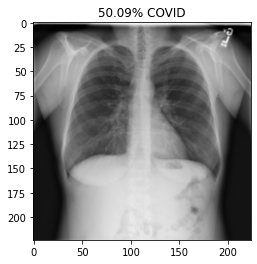

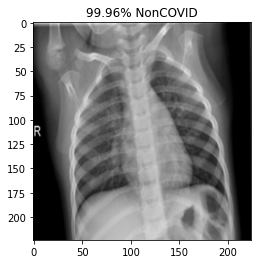

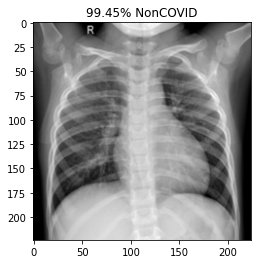

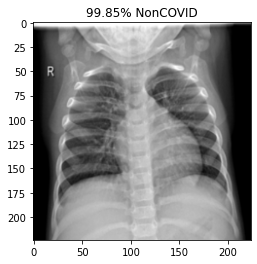

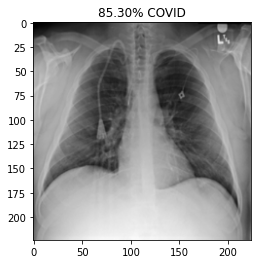

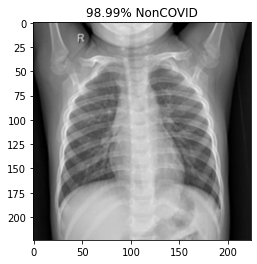

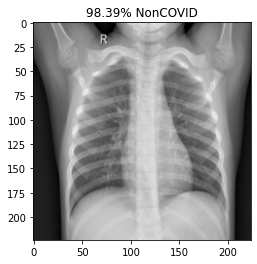

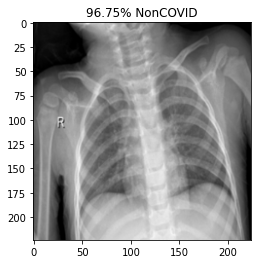

In [17]:
prediction=y_pred[0:10]
for index, probability in enumerate(prediction):
  if probability[1] > 0.5:
        plt.title('%.2f' % (probability[1]*100) + '% NonCOVID')
  else:
        plt.title('%.2f' % ((1-probability[1])*100) + '% COVID')
  plt.imshow(X_test[index])
  plt.show()

In [18]:
# Convert to Binary classes
y_pred_bin = np.argmax(y_pred, axis=1)
y_test_bin = np.argmax(y_test, axis=1)

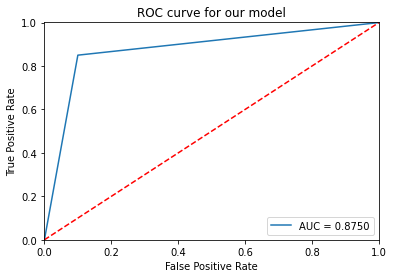

In [19]:
from sklearn.metrics import auc
fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_bin)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.title('ROC curve for our model')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();


Confusion Matrix without Normalization


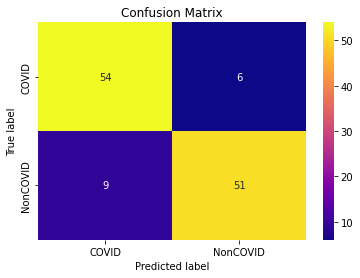

Confusion Matrix with Normalized Values


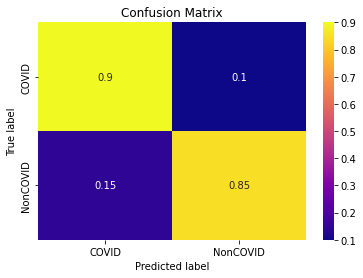

In [20]:
def plot_confusion_matrix(normalize):
  classes = ['COVID','NonCOVID']
  tick_marks = [0.5,1.5]
  cn = confusion_matrix(y_test_bin, y_pred_bin,normalize=normalize)
  sns.heatmap(cn,cmap='plasma',annot=True)
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  plt.title('Confusion Matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

print('Confusion Matrix without Normalization')
plot_confusion_matrix(normalize=None)

print('Confusion Matrix with Normalized Values')
plot_confusion_matrix(normalize='true')

In [21]:
from sklearn.metrics import classification_report
print(classification_report(y_test_bin, y_pred_bin))

              precision    recall  f1-score   support

           0       0.86      0.90      0.88        60
           1       0.89      0.85      0.87        60

    accuracy                           0.88       120
   macro avg       0.88      0.88      0.87       120
weighted avg       0.88      0.88      0.87       120



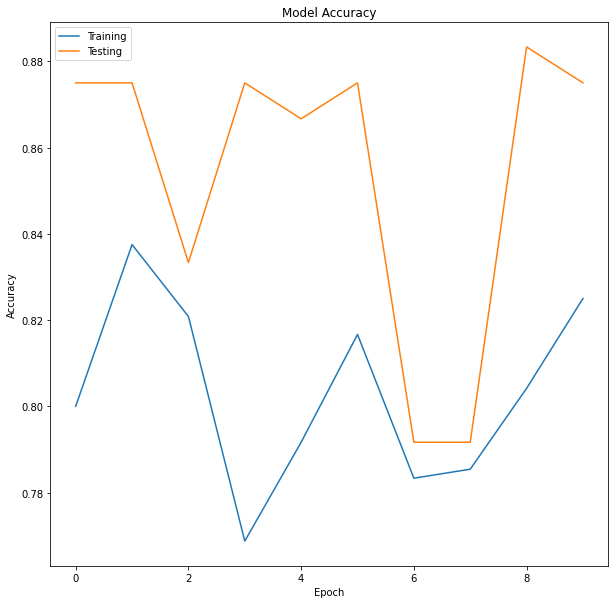

In [22]:
plt.figure(figsize=(10,10))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('resnet_chest_accuracy.png')
plt.show()

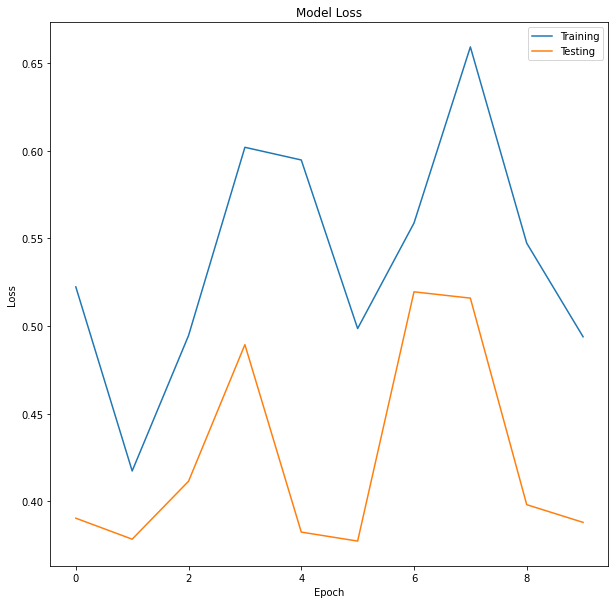

In [23]:
plt.figure(figsize=(10,10))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('resnet_chest_loss.png')
plt.show()

In [24]:
import numpy as np
import cv2
from tensorflow.keras.models import load_model

In [25]:
def test_rx_image_for_Covid19_2(model, imagePath):
    img = cv2.imread(imagePath)
    img_out = img
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    img = np.expand_dims(img, axis=0)
    img = np.array(img) / 255.0
    pred = model.predict(img)
    pred_neg = round(pred[0][1]*100)
    pred_pos = round(pred[0][0]*100)
    
    if np.argmax(pred, axis=1)[0] == 1:
        prediction = 'NEGATIVE'
        prob = pred_neg
    else:
        prediction = 'POSITIVE'
        prob = pred_pos
    cv2.imwrite('../Image_Prediction/Image_Prediction.png', img_out)
    return prediction, prob

In [26]:
covid_xception_model = load_model('/content/drive/MyDrive/dataset/resnet_chest.h5')

In [27]:
imagePath = '/content/drive/MyDrive/dataset/covid/COVID-1.png'
test_rx_image_for_Covid19_2(covid_xception_model, imagePath)

('POSITIVE', 99)

In [28]:
imagePath = '/content/drive/MyDrive/dataset/normal/Normal-1.png'
test_rx_image_for_Covid19_2(covid_xception_model, imagePath)

('NEGATIVE', 79)